In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import scipy.stats as spst

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %cd drive/My Drive
# %cd covid_simulation/
%cd /content/drive/MyDrive/covid_simulation

/content/drive/MyDrive/covid_simulation


In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
from people_generation import * 
from Citizen import * 
from infection_rate import *


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class Government(object) : 
    """ Government Agent """
    def __init__(self, policy : str, priority_period : list, days : int) : 
        self.policy = policy 
        self.processed_requests = []  
        self.priority_period = np.array(priority_period)
        self.days = days 
        self.current_day = 0 
    
    def get_policy(self):
        return self.policy

    def reset(self) : 
        self.processed_requests = []    

    def decide(self, requests_by_risk, susceptible_num_by_risk, requests_by_priority, 
                susceptible_num_by_priority, citizen_num, vaccines_num, requests, setting) : 
        """ governemnt decides if should give vaccine injection 
            setting : 
                - "full_info" : government has full information of the lining requests
                - "streaming" : requests comes in order, government needs to make decision for coming requests and process the next request
        
        """

        if setting == "full_info" : 
            vaccinated_ids = []
            if self.policy == "Unif" : 
              #Basis: vaccinate peopel uniformly without grouping 
                vaccinated_ids = sampling(vaccines_num, requests)

            elif self.policy == "UP" :  
                # Uniformly assign vaccines to each group
                for group_id in range(len(requests_by_priority)) : 
                    group_vaccine = vaccines_num * susceptible_num_by_priority[group_id] / citizen_num
                    vaccinated_ids.append(sampling(group_vaccine, requests_by_priority[group_id]))

            elif self.policy == "SP" or "pA": 
              # stratified policy: groups with higher priority get vaccination first
                i = 0
                max_i = len(requests_by_priority) - 1
                while vaccines_num > 0:
                    if i > max_i: break

                    group_ids = requests_by_priority[i]
                    if vaccines_num <= len(group_ids):
                      vaccinated_ids.append(sampling(vaccines_num, group_ids))
                      vaccines_num = 0
                    else:
                      vaccinated_ids.append(group_ids)
                      vaccines_num = vaccines_num - len(group_ids)

                    i += 1
            
            elif self.policy == "MP" : 
              # Mixture policy: period 1: health workers + seniors
                mixture_mask = (self.priority_period * self.days).astype(int) <= self.current_day 
                
                vac_group = []
                vac_num_by_group = []

                for pri_id, mixture_pri in enumerate(requests_by_priority) : 
                    if mixture_mask[pri_id] : 
                        vac_group.append(requests_by_priority[pri_id])
                        vac_num_by_group.append(susceptible_num_by_priority[pri_id])
                
                # if priority group vac num is positive 
                if np.sum(vac_num_by_group) > 0 : 
                    for group_id in range(len(vac_group)) : 
                        group_vaccine = vaccines_num * vac_num_by_group[group_id] / np.sum(vac_num_by_group)
                        vaccinated_ids.append(sampling(group_vaccine, vac_group[group_id]))
                        vaccines_num -= group_vaccine
                
                if vaccines_num > 0 : 
                    vac_group = []
                    vac_num_by_group = []

                    for pri_id, mixture_pri in enumerate(requests_by_priority) : 
                        if not mixture_mask[pri_id] : 
                            vac_group.append(requests_by_priority[pri_id])
                            vac_num_by_group.append(susceptible_num_by_priority[pri_id])
                    
                    for group_id in range(len(vac_group)) : 
                        group_vaccine = vaccines_num * vac_num_by_group[group_id] / np.sum(vac_num_by_group)
                        vaccinated_ids.append(sampling(group_vaccine, vac_group[group_id]))
                        vaccines_num -= group_vaccine
                
     
        elif setting == "streaming" : 
            if self.policy == "unif" : 
                vaccine_prob = vaccines_num / citizen_num 
                cur_decide = np.random.rand() < vaccine_prob
                return cur_decide
        
        self.days += 1 

        return vaccinated_ids 

In [ ]:
class vaccine_system(object) : 
    def __init__(self, gov, citizen_num, vaccine_num, days, r_nau, gamma, risk_group_num, priority_group_num, effective_rate, setting="full_info") :
        self.gov = gov 
        self.citizen_num = citizen_num
        self.gamma = gamma 
        self.citizen_stats = []
        self.gen_citizen(self.citizen_num)

        self.ids = np.array(self.citizen_stats[:, self.col_indx["id"]], dtype=int)
        self.risk_group_num = risk_group_num 
        self.priority_group_num = priority_group_num 

        # generate original infected number 
        ori_infected_num = int(np.ceil(self.citizen_num * 0.006))
        ori_infected_ids = np.random.choice(self.ids, ori_infected_num, replace=False)
        
        self.citizens_i_status = self.citizen_stats[:, self.col_indx["infected"]]
        self.citizens_i_status[ori_infected_ids] = 1 
        self.gammas = self.citizen_stats[:, self.col_indx["gamma"]]
        self.death_risk = self.citizen_stats[:, self.col_indx["death_risk"]].astype(float)
        
        self.risk_group = self.citizen_stats[:, self.col_indx["risk"]]
        self.risk_matrix = self.create_risk_matrix(self.risk_group_num)

        self.priority_group = self.citizen_stats[:, self.col_indx["priority"]]
        
        self.status_to_idx = {"susceptible" : 0, "infected" : 1, "anti_body" : 2, "ill" : 3} 
        self.vaccine_num = vaccine_num
        self.vaccinated = []
        self.days = days 
        self.r_nau = r_nau 

        # for control variate 
        self.ori_gammas = np.array(self.gammas)
        
        self.setting = setting
        self.current_day = 1
        self.effective_rate = effective_rate

        self.risk_infected_id_by_group = {}
        self.risk_susceptible_id_by_group = {}
        self.risk_requests_by_group = {}
        self.risk_anti_body_by_group = {}

        self.pri_infected_id_by_group = {}
        self.pri_susceptible_id_by_group = {}
        self.pri_requests_by_group = {} 
        self.pri_anti_body_by_group = {}

        self.risk_infected_num_by_group = np.zeros(self.risk_group_num)
        self.risk_susceptible_num_by_group = np.zeros(self.risk_group_num)
        self.pri_infected_num_by_group = np.zeros(self.priority_group_num)
        self.pri_susceptible_num_by_group = np.zeros(self.priority_group_num)

        self.grouping(True, True, True)
    
    def reset(self, gov, citizen_num, vaccine_num, days, r_nau, setting="full_info") : 
        """ reset all parameters for new simulation """
        pass 

    def grouping(self, update_id=False, update_risk=False, update_priority=False) : 
        if update_risk : 
            self.risk_infected_num_by_group = []
            self.risk_susceptible_num_by_group = []

            for group_id in range(self.risk_group_num) : 
                self.risk_infected_num_by_group.append(np.sum((self.citizens_i_status == 1) * (self.risk_group == group_id)) )
                self.risk_infected_id_by_group[group_id] = self.ids[(self.risk_group == group_id) * (self.citizens_i_status == 1)] 
                
                self.risk_susceptible_num_by_group.append(np.sum((self.citizens_i_status == 0) * (self.risk_group == group_id)) )
                self.risk_susceptible_id_by_group[group_id] = self.ids[(self.risk_group == group_id) * (self.citizens_i_status == 0)] 

            self.risk_infected_num_by_group = np.array(self.risk_infected_num_by_group)
            self.risk_susceptible_num_by_group = np.array(self.risk_susceptible_num_by_group)
            
        if update_priority : 
            self.pri_infected_num_by_group = []
            self.pri_susceptible_num_by_group = []

            for group_id in range(self.priority_group_num) : 
                self.pri_infected_num_by_group.append(np.sum((self.citizens_i_status == 1) * (self.priority_group == group_id)))
                self.pri_infected_id_by_group[group_id] = self.ids[(self.citizens_i_status == 1) * (self.priority_group == group_id) ]
                
                self.pri_susceptible_num_by_group.append(np.sum((self.citizens_i_status == 0) * (self.priority_group == group_id)))
                self.pri_susceptible_id_by_group[group_id] = self.ids[(self.citizens_i_status == 0) * (self.priority_group == group_id) ] 

            self.pri_infected_num_by_group = np.array(self.pri_infected_num_by_group)
            self.pri_susceptible_num_by_group = np.array(self.pri_susceptible_num_by_group)

    """Added by Faye: Assining groups for different policies"""
    def gen_group_for_policies(self, age, occupation, essential):
        policy = self.gov.get_policy()

        if policy in ["SP", "MP", "UP", "Unif"] :
            # healthcare workers
            if occupation < len(occ_lst) and occ_lst[occupation] == 'Health Care and Social Assistance' : 
                priority = 0
            # essential workers
            elif essential == 1: priority = 1 
            # seniors
            elif age > 65: priority = 2
            else: priority = 3

        elif policy == "pA": 
            # healthcare workers
            if occupation < len(occ_lst) and occ_lst[occupation] == 'Health Care and Social Assistance' : 
                priority = 0
            # seniors
            elif age > 65: priority = 1

            # essential workers
            elif essential == 1: priority = 2
            else: priority = 3
        
        return priority 

    def gen_citizen(self, citizen_num) : 
        """ generate virtual citizens """
        for i in range(citizen_num) : 
            info = Rn_Citizen()
            info["request_vaccine"] = False
            info["ill"] = False
            info["priority"] = self.gen_group_for_policies(info["age"], info["occupation"], info["essential"])
            info["id"] = i
            info["gamma"] = np.random.poisson(self.gamma)
            
            death_risk_params = ["age", "gender", "ethnicity", "weight", "height", "home_cat", "diabetes_type", "if_cancer"]
            death_risk_params = {key : value for key, value in info.items() if key in death_risk_params}
            #info["death_risk"] = Citizen.get_sick_after_infection(**death_risk_params)
            info["death_risk"] = Citizen.simple_death_rate(info["age"])

            info["risk"] = None 

            for risk_id, occupations in enumerate(occupation_by_risk) :     
                if info["occupation"] < len(occ_lst) and occ_lst[info["occupation"]] in occupations : 
                    info["risk"] = len(occupation_by_risk) - risk_id - 1

            if info["occupation"] == len(occ_lst) : 
                info["risk"] = 5

            self.citizen_stats.append(list(info.values()))
        
        self.citizen_stats = np.array(self.citizen_stats)
        self.col_indx = {key : idx for idx, key in enumerate(info.keys())}

        return 

    def recovery(self, re, ill_rate=0.1, method="resolve") : 
        """ simulate the recovery """

        # get the recovery index for infected people getting resolved 
        if method == "ratio" :  
            recovery_num = int(np.sum(self.citizens_i_status) * re) 
            new_recovery_idx = list(np.random.choice(np.arange(np.sum(self.citizens_i_status)), recovery_num, replace=False))

        elif method == "resolve" :
            gamma_mask = self.gammas == 0 
            infect_mask = self.citizens_i_status == 1 
            resolve_mask = gamma_mask * infect_mask
            new_resolve_idx = self.ids[resolve_mask]

            ill_mask = np.random.rand(len(self.death_risk)) < self.death_risk
            self.ill_idx = self.ids[resolve_mask * ill_mask]
        
        self.healthy_new_resolve_idx = np.setdiff1d(new_resolve_idx, self.ill_idx)

    def infection_spread(self, r_nau, infectious_period=5, random_mode=True) :
        """ simulate the infection """
        
        # compute infect parameter for each group 
        group_infect_param = np.matmul(self.risk_matrix, self.risk_infected_num_by_group) / self.citizen_num

        # compute infect num from each group's susceptible 
        group_newly_infected_num = self.risk_susceptible_num_by_group * group_infect_param

        # sample infected id from each group 
        group_newly_infected_id = [sampling(group_newly_infected_num[group_id], self.risk_susceptible_id_by_group[group_id]) for group_id in range(self.risk_group_num)]
        self.group_newly_infected_id = group_newly_infected_id


    def update(self) : 
        """" implements recovery, infection -> vaccine injection """
        # recover 
        self.recovery(0.1)
        
        # infection spread 
        noise = np.random.normal()
        noise = 1 if noise < -self.r_nau else noise  
        noisy_r_nau = self.r_nau + noise 
        self.infection_spread(noisy_r_nau, 5)
        
        # update from last day's stat 
        self.citizens_i_status[self.healthy_new_resolve_idx] = 2 
        self.citizens_i_status[self.ill_idx] = 3 

        for group_id in range(self.risk_group_num) : 
            self.citizens_i_status[self.group_newly_infected_id[group_id]] = 1 
        
        zero_gamma_mask = self.gammas == 0 
        pos_gamma_mask = self.gammas > 0 
        
        infect_mask = self.citizens_i_status == 1 
        gamma_update_num = np.sum(zero_gamma_mask)

        self.gammas[zero_gamma_mask] = np.random.poisson(self.gamma, gamma_update_num)
        self.gammas[pos_gamma_mask * infect_mask] -= 1 
        
        self.grouping(False, True, True)

        effective_rate = self.effective_rate
        effective_num = self.vaccine_num / self.days * effective_rate

        # assume the effectiveness is immedately known 
        request_len = np.sum(self.citizens_i_status == 0)
        if request_len > effective_num : 

            # goverment implements policy    
            if self.setting == "full_info" :  
                if request_len > effective_num :    
                    vaccinated_idx = self.gov.decide(self.risk_susceptible_id_by_group, self.risk_susceptible_num_by_group, self.pri_susceptible_id_by_group, \
                                            self.pri_susceptible_num_by_group, request_len, effective_num, self.ids[self.citizens_i_status == 0], setting)

                    # remove vaccinated request of each group, add them into anti body  
                    for group_id in range(len(vaccinated_idx)) : 
                        self.citizens_i_status[vaccinated_idx[group_id]] = self.status_to_idx["anti_body"] 

                    self.grouping(False, True, True)

                else : 
                    vaccinated_idx = np.arange(request_len)
            elif self.setting == "streaming" : 
                vaccinated_idx = []
                idx = 0 
                while effective_num > 0 and idx < request_len: 
                    current_request = self.ids[idx]
                    cur_decide = self.gov.decide([current_request], request_len, effective_num, self.setting)
                    if cur_decide : 
                        vaccinated_idx.append(idx)
                        effective_num -= 1 
                    idx += 1 
        
            self.current_day += 1 

    def start(self) : 
        """ start simulation """
        infected_num = []
        uninfected_num = []
        requests_num = []
        anti_body_num = []
        ill_num = []
        
        group_infected_num = []
        group_uninfected_num = []
        group_requests_num = []
        group_anti_body_num = []
        group_ill_num = []

        # update for the given days 
        for i in range(self.days) : 
            self.update()
            infected_num.append(np.sum(self.citizens_i_status == 1))
            uninfected_num.append(self.citizen_num - np.sum(self.citizens_i_status == 1) - np.sum(self.citizens_i_status == 3))
            requests_num.append(np.sum(self.citizens_i_status == 0))
            anti_body_num.append(np.sum(self.citizens_i_status == 2))
            ill_num.append(np.sum(self.citizens_i_status == 3))
            
            for group_id in range(self.priority_group_num) : 
                group_infected_num.append(self.pri_infected_num_by_group)
                group_uninfected_num.append(self.citizen_num - np.sum( (self.priority_group == group_id) *\
                                        ( (self.citizens_i_status == 1) | (self.citizens_i_status == 3) ) ) )
                group_requests_num.append(np.sum( (self.priority_group == group_id) * (self.citizens_i_status == 0) ) )
                group_anti_body_num.append(np.sum( (self.priority_group == group_id) * (self.citizens_i_status == 2) ) )
                group_ill_num.append(np.sum( (self.priority_group == group_id) * (self.citizens_i_status == 3) ))

        control_variate = self.ori_gammas[self.citizens_i_status == 2]
        return infected_num, uninfected_num, requests_num, anti_body_num, ill_num,\
                group_infected_num, group_uninfected_num, group_requests_num, group_anti_body_num, group_ill_num, np.mean(control_variate)
        
    def create_risk_matrix(self, row) : 
        """ create cross-group contact-risk matrix """
        mat = np.zeros((row, row))
        deltas = [1, 0.8, 0.6, 0.4, 0.3, 0.1]
        for i in range(row) : 
            delta = deltas[i]
            for j in range(i, row) : 
                if i == j : 
                    mat[i, j] = 1 * delta 
                else : 
                    mat[i, j] = (1 - 0.15 * (j - i)) * delta 
        
        for i in range(row) : 
            for j in range(i) : 
                mat[i, j] = mat[j, i]
        
        return mat 
        
def sampling(target_num, id_to_sample) : 
        if len(id_to_sample) > np.ceil(target_num) : 
            sampled_id = np.random.choice(id_to_sample, int(np.ceil(target_num)), replace=False)
        else : 
            sampled_id = id_to_sample
        
        return sampled_id 

def simulate(sim_num = 1, sim_params=None) : 
    """ implements a whole run of simulation for a period """
    infected_nums = []
    uninfected_nums = []
    requests_nums = []
    anti_body_nums = []
    ill_nums = []

    group_infected_nums = []
    group_uninfected_nums = []
    group_requests_nums = []
    group_anti_body_nums = []
    group_ill_nums = []
    control_variates = []

    for i in range(sim_num) : 
        env = vaccine_system(**sim_params)
        infected_num, uninfected_num, requests_num, anti_body_num, ill_num,\
                group_infected_num, group_uninfected_num, group_requests_num, group_anti_body_num, group_ill_num, control_variate = env.start() 

        infected_nums.append(infected_num)
        uninfected_nums.append(uninfected_num)
        requests_nums.append(requests_num)
        anti_body_nums.append(anti_body_num)
        ill_nums.append(ill_num)

        group_infected_nums.append(group_infected_num)
        group_uninfected_nums.append(group_uninfected_num)
        group_requests_nums.append(group_requests_num)
        group_anti_body_nums.append(group_anti_body_num)
        group_ill_nums.append(group_ill_num)
        control_variates.append(control_variate)

    stats = {}
    stats["infected_num"] = infected_nums
    stats["uninfected_num"] = uninfected_nums
    stats["request_num"] = requests_nums
    stats["anti_body_num"] = anti_body_nums
    stats["ill_num"] = ill_nums 
    stats["control_variate"] = control_variates

    group_stats = {}
    group_stats["infected_num"] = group_infected_nums
    group_stats["uninfected_num"] = group_uninfected_nums
    group_stats["request_num"] = group_requests_nums
    group_stats["anti_body_num"] = group_anti_body_nums
    group_stats["ill_num"] = group_ill_nums 

    return stats, group_stats

def collect_stats(data, axis, sample_mean=False) : 
    """ collect means and std """
    num = len(data)
    mean = np.mean(data, axis=axis)
    std = np.std(data, axis=axis)

    mean_std = std / (num ** (1/2)) if sample_mean else std 

    return mean, mean_std 

def main_sim(parameters : dict, sim_num : int, stats_type : str, stats_digit_form : str, popultaion : bool, metric : str, policy_compare : str, single_param=False) :
    """ run all simulations and plotting time-varying graphs 
        
        Arguments : 
        - parameters : make sure that only one of the keys correspond to list values, mainly for params comparison 
        - sim_num : simulation number 
        - stats : stats chosen for plots 
            - population : 
                - "basic" : output a) "infected_num", "uninfected_num", b) "request_num", "anti_body_num", "seriously_ill_num"
                - "vaccine_control " : output metric that measure the performance of vaccine : "infected_num" + "seriously_ill_num"
            - group : 
                - for better visualization, we provide arguments : 
                    - all_group with single metrics 
        - stats_digit_form : either number or percentage 
    """
    params_key = parameters.keys()
    days = parameters["days"] if parameters["days"] else 7 
    ori_citizen_num = parameters["citizen_num"]
    temp_parameters = parameters 

    policies = parameters.pop("policy")

    # select the params values for comparison 

    if not single_param : 
        compare_key_num = 0 
        for param in params_key : 
            if type(parameters[param]) is list and len(parameters[param]) > 1 : 
                temp_param_values = parameters[param]
                temp_param_key = param 
                temp_parameters.pop(param)
                temp_params = temp_parameters
                compare_key_num += 1 
                break 
        
        # if not for comparison, create singleton list 
        if not compare_key_num : 
            temp_params = temp_parameters
            temp_param_key = list(temp_params.keys())[0]
            temp_param_values = [temp_params[temp_param_key]]
    else : 
        temp_params = temp_parameters
        temp_param_key = list(temp_params.keys())[0]
        temp_param_values = [temp_params[temp_param_key]]
        compare_key_num = 0 

    # deploy plot structure 
    unit_width, unit_len = 6, 6
    
    if popultaion : 
        if not metric : 
            if stats_type == "basic" : 
                fig_width, fig_len = 2 * unit_width, len(temp_param_values) * unit_len
                fig, axes = plt.subplots(2, len(temp_param_values), figsize=(fig_len, fig_width))
            else : 
                fig_width, fig_len = 1 * unit_width, len(temp_param_values) * unit_len
                fig, axes = plt.subplots(1, len(temp_param_values), figsize=(fig_len, fig_width))
        
        else : 
            fig_width, fig_len = 1 * unit_width, len(temp_param_values) * unit_len
            fig, axes = plt.subplots(1, len(temp_param_values), figsize=(fig_len, fig_width))
    
    else : 
        fig_width, fig_len = 1 * unit_width, len(temp_param_values) * unit_len
        fig, axes = plt.subplots(1, len(temp_param_values), figsize=(fig_len, fig_width))
    
    priority_period = list(parameters["priority_period"])
    parameters.pop("priority_period")

    # compare param values 
    stats_dict = {}
    group_stats_dict = {} 

    for idx, param_value in enumerate(temp_param_values) :         
        temp_params[temp_param_key] = param_value
        
        for policy in policies : 
            gov = Government(policy, priority_period, days)
            if policy not in stats_dict.keys() : 
                stats_dict[policy] = []
                group_stats_dict[policy] = []

            temp_params["gov"] = gov 
            stats, group_stats = simulate(sim_num=sim_num, sim_params=temp_params)

            if stats_digit_form == "number" : 
                ori_citizen_num = 1 
            
            for key, value in list(stats.items()) : 
                stats[key] = np.array(value) / ori_citizen_num
            
            for key, value in list(group_stats.items()) : 
                group_stats[key] = np.array(value) / ori_citizen_num

            x_label = "days" 
            y_label = "percentage" if stats_digit_form == "percent" else "num"
            
            stats_dict[policy].append(stats) 
            group_stats_dict[policy].append(group_stats)
            

            if popultaion : 
                # show all metric, plot structure : 2 * (# of params of compare)
                if not metric : 
                    if stats_type == "basic" : 
                        labels = ["infected_num", "uninfected_num"]
                        datas = [stats[label] for label in labels]
                        
                        ax = axes[0][idx] if compare_key_num else axes[0]
                        plotting(datas, labels, days, ax=ax, title=(temp_param_key, param_value), x_label=x_label, y_label=y_label)

                        labels = ["request_num", "anti_body_num", "ill_num"]
                        datas = [stats[label] for label in labels]

                        ax = axes[1][idx] if compare_key_num else axes[1]

                        plotting(datas, labels, days, ax=ax, title=None, x_label=x_label, y_label=y_label)

                    elif stats_type == "vaccine_control" : 
                        labels = ["unsolved_num"]
                        datas = [stats["infected_num"] + stats["ill_num"]]
                        
                        ax = axes[idx] if compare_key_num else axes
                        sub_title = (temp_param_key, param_value) if compare_key_num else None  
                        plotting(datas, labels, days, ax=ax, title=sub_title, x_label=x_label, y_label=y_label)
                else : 
                    labels = [policy]
                    for m in metric:
                      if m == "vaccine_control" : 
                          datas = [stats["infected_num"] + stats["ill_num"]]
                          y_label = "unsolved"
                          
                      else : 
                          datas = [stats[m]]
                          y_label = m 

                      ax = axes[idx] if compare_key_num else axes
                      plotting(datas, labels, days, ax=ax, title=(temp_param_key, param_value), x_label=x_label, y_label=y_label, group=False)
            
            else : 

                if stats_type == "basic" : 
                    assert metric is not None 
                    datas = group_stats[metric]
                    labels = metric

                    ax = axes[idx] if compare_key_num else axes
                    
                    plotting(datas, labels, days, ax=ax, title=(temp_param_key, param_value), x_label=x_label, y_label=y_label, group=True)
            
    plt.show()
    
    return stats_dict, group_stats_dict

def plotting(datas, labels, days, ax, title, x_label, y_label, group=False) :  
    epochs = np.arange(1, days+1)

    if not group : 
        for idx, data in enumerate(datas) :    
            mean, std = collect_stats(data, 0)
            ax.plot(epochs, mean, label=labels[idx])
            #ax.fill_between(epochs, mean-std, mean+std ,alpha=0.1)
            ax.set_xlabel(x_label)
            ax.set_ylabel(y_label)
            
            if title : 
                param_key, param_value = title 
                ax.set_title(param_key + " : " + str(param_value))
            
            ax.legend()
    
    if group : 
        mean, std = collect_stats(datas, 0)
        group_num = mean.shape[1]
        for group_id in range(group_num) : 
            group_mean = mean[:, group_id]
            group_std = std[:, group_id]
            ax.plot(epochs, group_mean, label="group {}".format(group_id))
            ax.fill_between(epochs, group_mean-group_std, group_mean+group_std ,alpha=0.1)
            ax.set_xlabel(x_label)
            ax.set_ylabel(y_label)
            
            if title : 
                param_key, param_value = title 
                ax.set_title(param_key + " : " + str(param_value) + ", metric : " + labels)
            
            ax.legend()

## Basic model without vaccine output

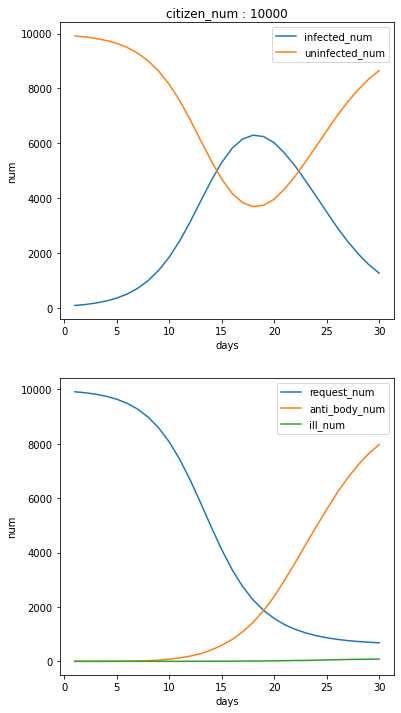

In [ ]:
# basic characterization 
policy = "UP"
setting = "full_info"
priority_period = [0]
days = 30
sim_num = 2
#max_daily_vaccine = np.ceil(citizen_num / days)  
# change vaccine number to daily capacity : more understandable 
params = {"citizen_num" : 10000, "vaccine_num" : 0, 
            "days" : days, "r_nau" : 1.5, "gamma" : 10, "setting" : setting, "effective_rate" : 0.9, 
            "risk_group_num" : 6, "priority_group_num" : 4, "policy" : ["Unif"], "priority_period" : priority_period}
datas = main_sim(params, sim_num=sim_num, stats_type="basic", stats_digit_form="number", popultaion=True, metric=None, policy_compare=True)

### Control Variate to for variance reduction 
In here we are interested in the average anti body number, which includes 
the people who obtain anti body after infection. We choose the control variate to be the resolving period (days), which in our assumption follows poission distribution. It decides if an infected people will get anti body before the last day, therefore related to the system output. 

In [ ]:
stats_dict, group_stats_dict = datas

In [ ]:
#data 
data = stats_dict["Unif"]
data[0].keys()

dict_keys(['infected_num', 'uninfected_num', 'request_num', 'anti_body_num', 'ill_num', 'control_variate'])

In [ ]:
data = stats_dict["Unif"]
x = data[0]["anti_body_num"][:, -1]
z = data[0]["control_variate"]
c = -np.cov(x, z, ddof=1)[0,1] / np.var(z, ddof=1)
y = x + c * (z - 10)

mean = np.mean(y)
std = np.std(y, ddof=1)
lower = mean - spst.norm.ppf(0.975) * std / sim_num ** 0.5
upper = mean + spst.norm.ppf(0.975) * std / sim_num ** 0.5
print("Control-variate : anti body number mean : {}, 95% confidence interval : {}--{}, width of confidence interval : {}".format(mean, lower, upper, upper - lower))

# verify variance reduction 
mean = np.mean(x)
std = np.std(x, ddof=1)
lower = mean - spst.norm.ppf(0.975) * std / sim_num ** 0.5
upper = mean + spst.norm.ppf(0.975) * std / sim_num ** 0.5
print("Original : anti body number mean : {}, 95% confidence interval : {}--{}, width of confidence interval : {}".format(mean, lower, upper, upper - lower))

Control-variate : anti body number mean : 7543.192151618579, 95% confidence interval : 7543.192151618579--7543.192151618579, width of confidence interval : 0.0
Original : anti body number mean : 7970.0, 95% confidence interval : 7960.2001800773--7979.7998199227, width of confidence interval : 19.599639845400816


## Policy Performance Comparison 

Group Assignment for UP, SP, MP:
Priority 0: healthcare workers
Priority 1: essential workers
Priority 2: seniors(age > 65)
Priority 3: others

Unif (control group): vaccinate people uniformly without grouping 

UP (uniformly-priority policy): uniformly assign vaccines to each group

SP (stratifiedly-priority policy): groups with higher priority get vaccination first 

MP (Mixture policy): assign vaccines to a mixture of groups during each periods of time. E.g., assign group 1 and group 2 first during the first 1/3 days

pA (prioritize-age policy): same as SP but with prioritizing seniors as 1 and essential works as 2

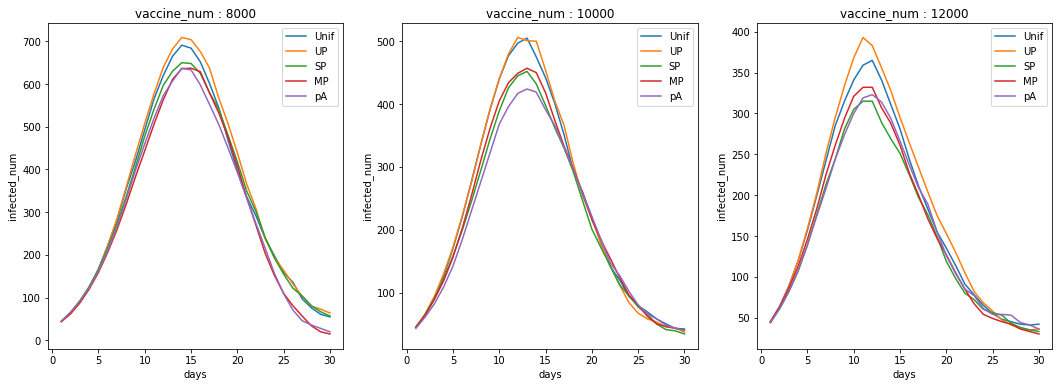

In [ ]:
policy = "UP"
setting = "full_info"
priority_period = [0, 0, 0.1, 0.2]
days = 30
citizen_num = 5000 
#max_daily_vaccine = np.ceil(citizen_num / days)  
# change vaccine number to daily capacity : more understandable 
params = {"citizen_num" : 5000, "vaccine_num" : [8000, 10000, 12000], 
            "days" : days, "r_nau" : 1.5, "gamma" : 10, "setting" : setting, "effective_rate" : 0.9, 
            "risk_group_num" : 6, "priority_group_num" : 4, "policy" : ["Unif", "UP","SP","MP", "pA"], "priority_period" : priority_period}
datas = main_sim(params, sim_num=1, stats_type="basic", stats_digit_form="number", popultaion=True, metric=["infected_num"], policy_compare=True)



## Policy Robustness Comparison 

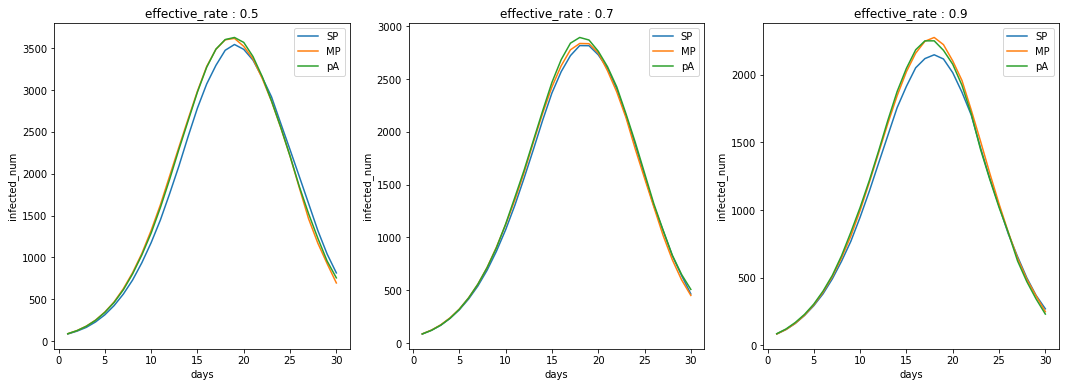

In [ ]:
priority_period = [0, 1/3, 1/2, 2/3]
params = {"citizen_num" : 10000, "vaccine_num" : 10000, "effective_rate" : [0.5, 0.7, 0.9], 
            "days" : days, "r_nau" : 1.5, "gamma" : 10, "setting" : setting, 
            "risk_group_num" : 6, "priority_group_num" : 4, "policy" : ["SP", "MP", "pA"], "priority_period" : priority_period}
datas = main_sim(params, sim_num=1, stats_type="basic", stats_digit_form="number", popultaion=True, metric=["infected_num"], policy_compare=False)

## Policy comparison for controlling max infected number peak  

In [ ]:
def plot_max(stats_dict, param_x, param_label) : 
    
    for policy_key, data in stats_dict.items() : 
        param_max = []
        for param_id in range(len(data)) : 
            infect_max = np.max(data[param_id]["infected_num"], axis=1)
            avg_infect_max = np.mean(infect_max)
            param_max.append(avg_infect_max)
        
        plt.plot(param_x, param_max, label=policy_key)
    
    plt.xlabel(param_label)
    plt.ylabel("infected number peak")
    plt.legend()

In [ ]:
stats_dict, group_stats_dict = datas 
# stats_dict["Unif"][0]

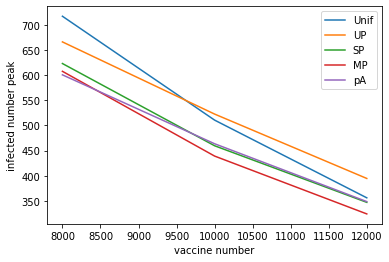

In [ ]:
plot_max(stats_dict, [8000, 10000, 12000], "vaccine number")

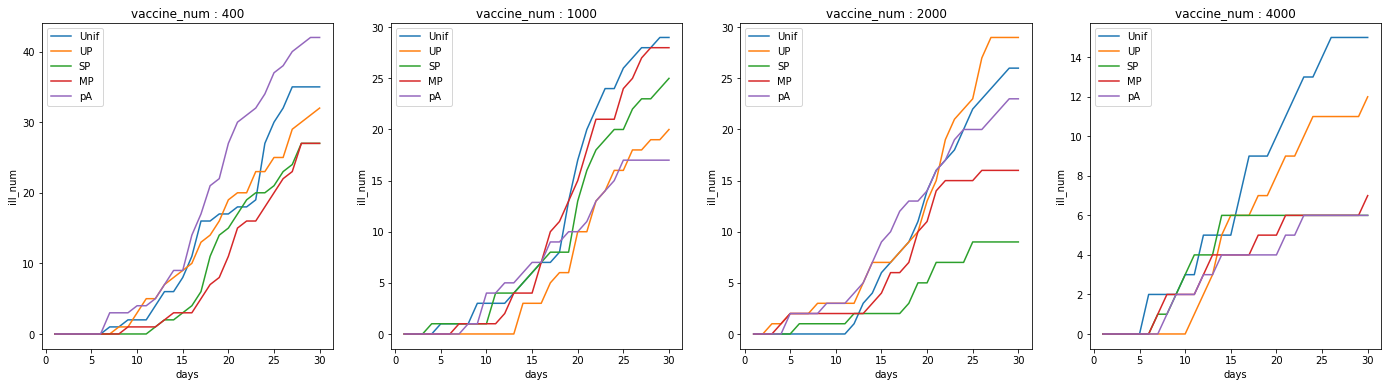

In [ ]:
policy = "UP"
setting = "full_info"
priority_period = [0, 1/3, 1/2, 2/3]
days = 30

params = {"citizen_num" : 5000, "vaccine_num" : [400, 1000, 2000, 4000], 
            "days" : days, "r_nau" : 1.5, "gamma" : 5, "setting" : setting, "effective_rate" : 0.9, 
            "risk_group_num" : 6, "priority_group_num" : 4, "policy" : ["Unif", "UP","SP","MP", "pA"], "priority_period" : priority_period}
datas = main_sim(params, sim_num=1, stats_type="basic", stats_digit_form="number", popultaion=True, metric=["ill_num"], policy_compare=True)




With the vaccine supply increasing, it takes less days to decrease the number of infected cases（reasonable). In this 30-day simulation, it takes 10 to 20 days to control the cases with total vaccine supply from 2 times citizen_num to 0.1 times citizen_num.

We can see clearly from the plots that policies SP, MP, and pA yield better results in controlling infected cases than uniformly allocation without prioritizing each group.


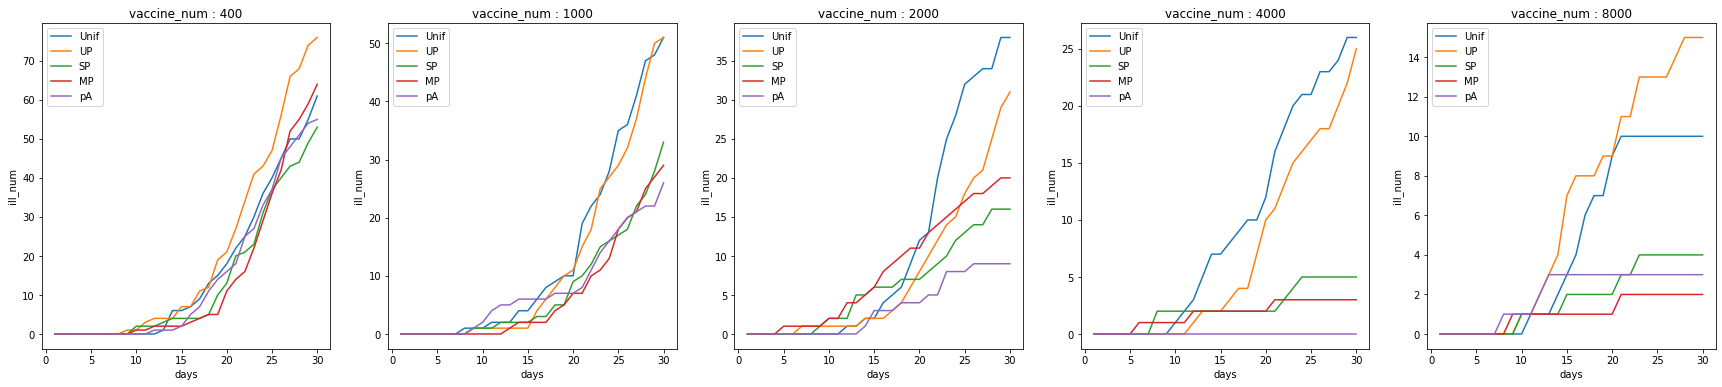

In [ ]:
policy = "UP"
setting = "full_info"
priority_period = [0, 1/3, 2/3, 3/4]
days = 30
params = {"citizen_num" : 4000, "vaccine_num" : [400, 1000, 2000, 4000, 8000], 
            "days" : days, "r_nau" : 1.5, "gamma" : 10, "setting" : setting, "effective_rate" : 0.9, 
            "risk_group_num" : 6, "priority_group_num" : 4, "policy" : ["Unif", "UP", "SP", "MP", "pA"], "priority_period" : priority_period}
datas_1 = main_sim(params, sim_num=1, stats_type="basic", stats_digit_form="number", popultaion=True, metric=["ill_num"], policy_compare=True)


See from above plots that the number of cases of severe illness grows slower if vaccinate groups with high death rate such as seniors.

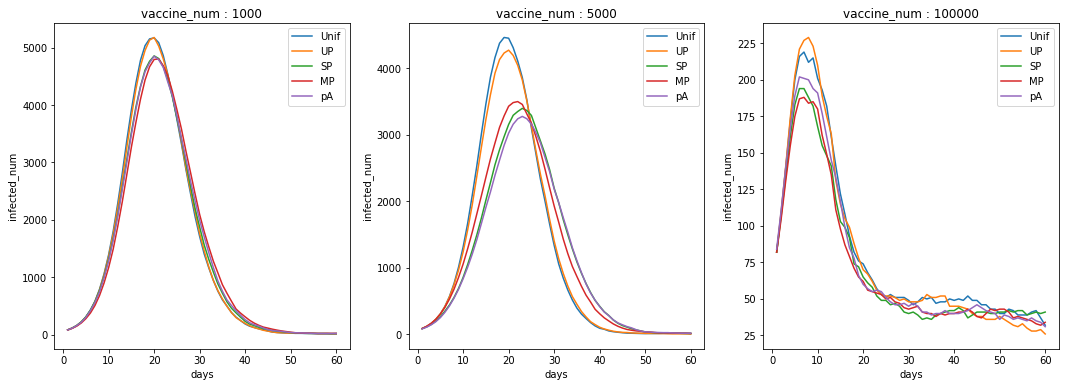

In [ ]:
policy = "UP"
setting = "full_info"
priority_period = [0, 1/3, 2/3, 3/4]
days = 60
params = {"citizen_num" : 10000, "vaccine_num" : [1000, 5000, 100000], 
            "days" : days, "r_nau" : 1.5, "gamma" : 10, "setting" : setting, "effective_rate" : 0.9, 
            "risk_group_num" : 6, "priority_group_num" : 4, "policy" : ["Unif","UP", "SP", "MP","pA"], "priority_period" : priority_period}
datas = main_sim(params, sim_num=1, stats_type="basic", stats_digit_form="number", popultaion=True, metric=["infected_num"], policy_compare=True)

In this two-month-10000-citizen simulation, MP outperforms others when supply of vaccines is relatively adequate (i.e. as 2 times as the number of citizens).

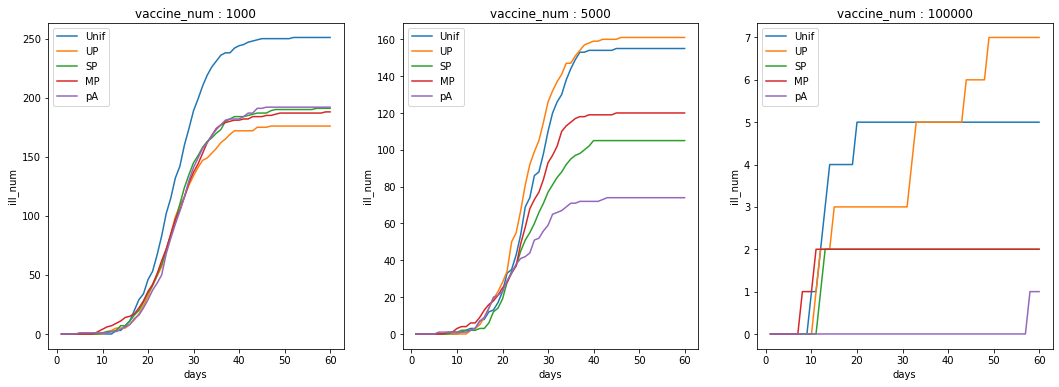

In [ ]:
policy = "UP"
setting = "full_info"
priority_period = [0, 1/3, 2/3, 3/4]
days = 60
params = {"citizen_num" : 10000, "vaccine_num" : [1000, 5000, 100000], 
            "days" : days, "r_nau" : 1.5, "gamma" : 10, "setting" : setting, "effective_rate" : 0.9, 
            "risk_group_num" : 6, "priority_group_num" : 4, "policy" : ["Unif","UP", "SP", "MP","pA"], "priority_period" : priority_period}
datas = main_sim(params, sim_num=1, stats_type="basic", stats_digit_form="number", popultaion=True, metric=["ill_num"], policy_compare=True)

pA (vaccinate-seniors-first policy) controls the number of severe-ill cases the best.

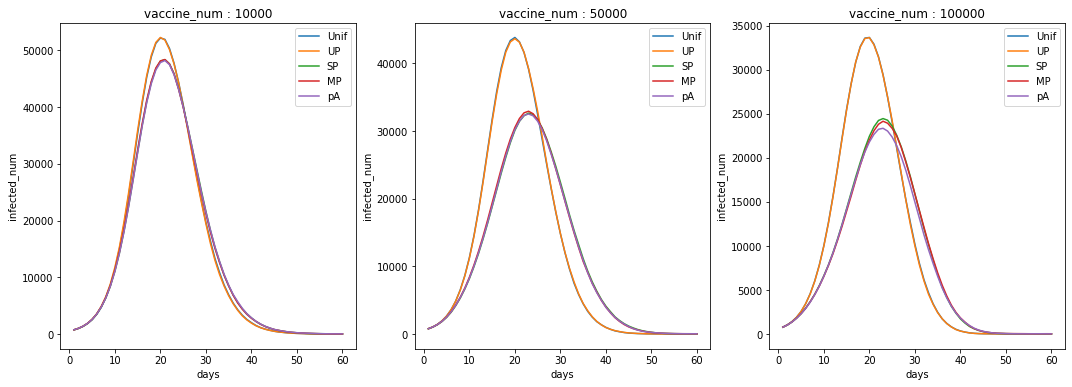

In [ ]:
policy = "UP"
setting = "full_info"
priority_period = [0, 1/3, 2/3, 3/4]
days = 60
params = {"citizen_num" : 100000, "vaccine_num" : [10000, 50000, 100000], 
            "days" : days, "r_nau" : 1.5, "gamma" : 10, "setting" : setting, "effective_rate" : 0.9, 
            "risk_group_num" : 6, "priority_group_num" : 4, "policy" : ["Unif","UP", "SP", "MP","pA"], "priority_period" : priority_period}
datas = main_sim(params, sim_num=1, stats_type="basic", stats_digit_form="number", popultaion=True, metric=["infected_num"], policy_compare=True)

## Policy optimization for mixture policy 

In [ ]:
def get_infected(policy, datas) : 
    temp_infect = datas[policy][0]["infected_num"]
    avg_infected_num = np.mean(temp_infect) 

    return avg_infected_num

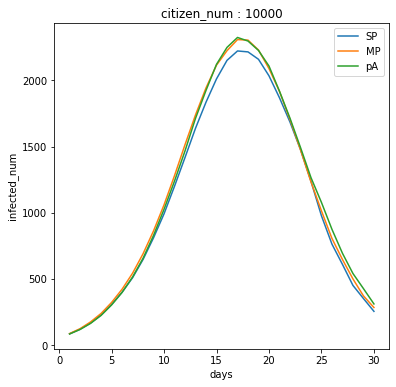

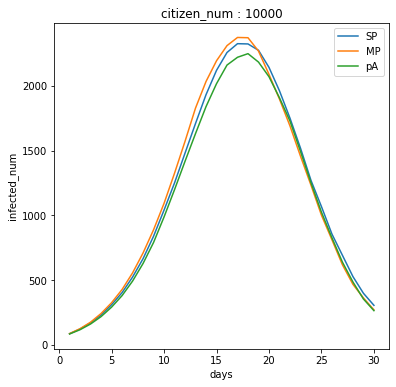

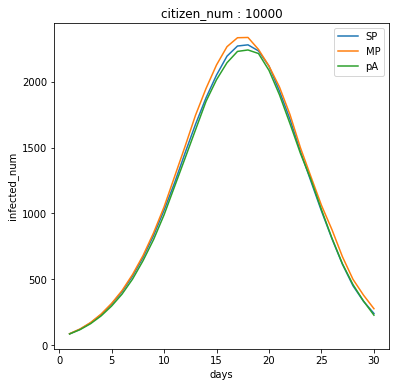

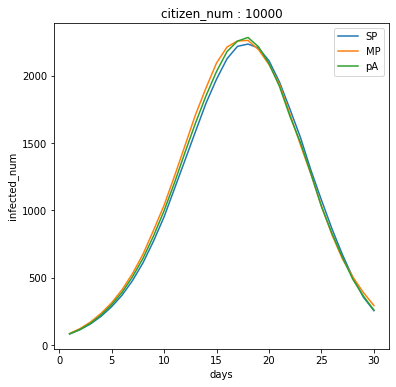

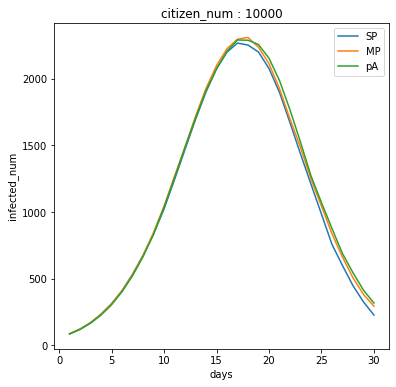

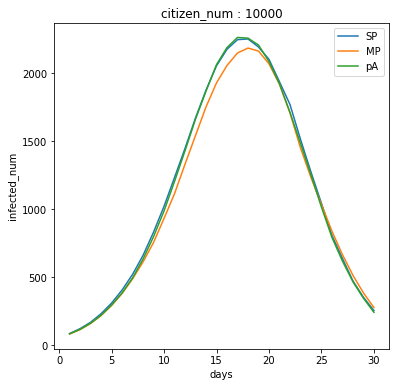

nice output


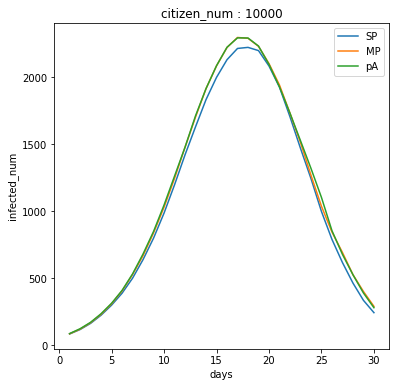

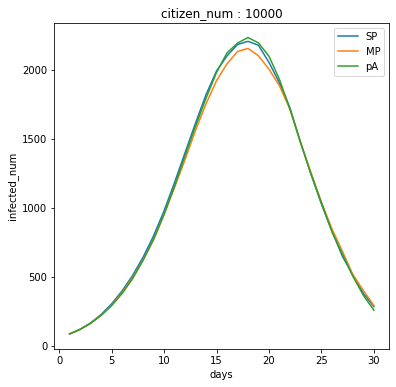

nice output


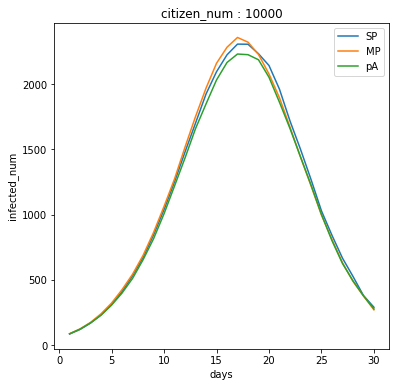

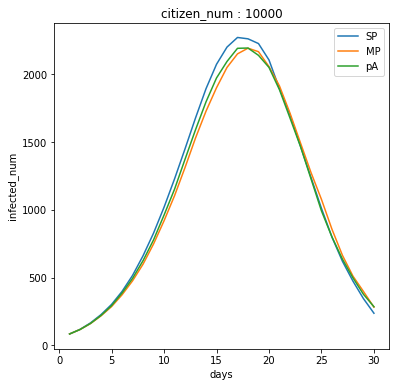

nice output


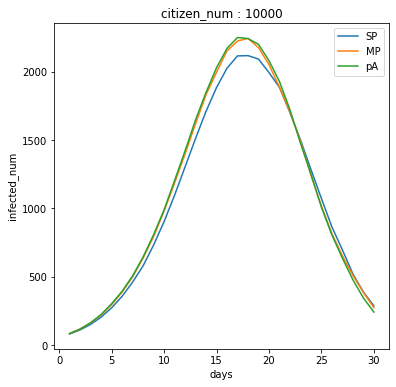

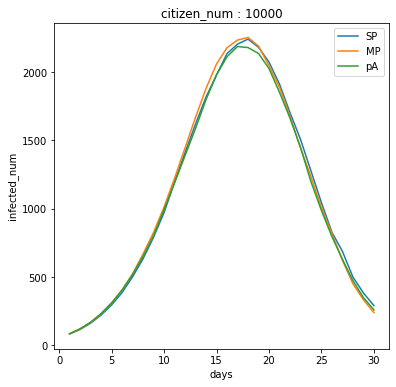

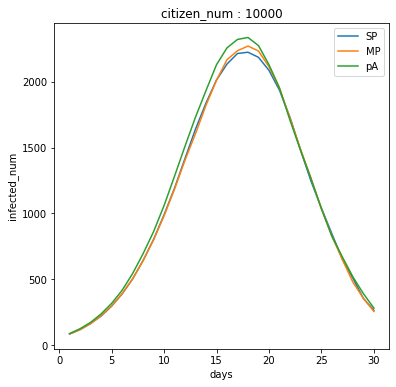

[(0.2, 0.2), (0.2, 0.6000000000000001), (0.3, 0.3)]


In [ ]:
setting = "full_info"
# priority_period = [0, 0, 0.1, 0.2]
days = 30
citizen_num = 10000 

min_infected = np.inf  
priority_period = [0, 0.3] 
opt_pp = [0 for i in range(4)]
t2 = 0
t3 = 0 
opt_set = []
opt_infected = []
for t2 in [0.1, 0.2, 0.3] : 
    priority_period.append(t2)  
    for t3 in np.arange(t2, 1, 0.2) : 
        priority_period.append(t3)  
        params = {"citizen_num" : 10000, "vaccine_num" : 10000, 
                    "days" : days, "r_nau" : 1.5, "gamma" : 10, "setting" : setting, "effective_rate" : 0.9, 
                    "risk_group_num" : 6, "priority_group_num" : 4, "policy" : ["SP","MP", "pA"], "priority_period" : priority_period}
        datas = main_sim(params, sim_num=1, stats_type="basic", stats_digit_form="number", popultaion=True, metric=["infected_num"], policy_compare=True, single_param=True)
        stats_dict, group_stats_dict = datas 

        tgt_infected_num = get_infected("MP", stats_dict)
        sp_infected_num = get_infected("SP", stats_dict)
        pa_infected_num = get_infected("pA", stats_dict)
        if tgt_infected_num < sp_infected_num and tgt_infected_num < pa_infected_num : 
            print("nice output")
            opt_infected.append(tgt_infected_num)
            opt_set.append((t2, t3))

    priority_period = [0, 0.3] 

print(opt_set) 

In [ ]:
print(opt_set, opt_infected)

[(0.2, 0.2), (0.2, 0.6000000000000001), (0.3, 0.3)] [1079.0, 1077.8666666666666, 1078.7333333333333]
